You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


In [3]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Experimental data

## select files and channels

In [4]:
cn = 53

NGD2L1DASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon         14.217523
gamma        73996.448279
omegastar       44.711774
deltastar        0.285205
tau_y            0.071035
Dmp             17.541824
error            0.093686
Name: 52, dtype: float64

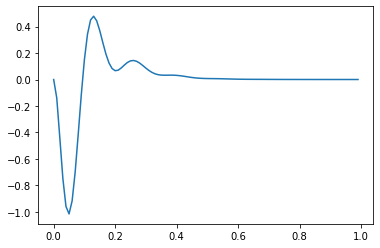

In [5]:
dt = 0.01
T = np.arange(0, 1., dt)
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))

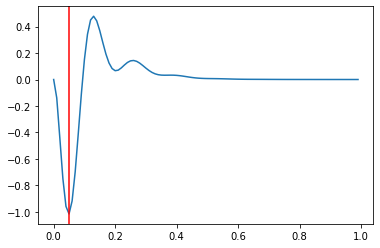

In [6]:
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))
plt.axvline(dt*5, c = 'r')

In [7]:
Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]


x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [8]:
# from scipy.fft import fft, fftfreq
# c=10
# for x in x_list:
#     yf = fft(x)
#     xf = fftfreq(len(x), dt)
#     plt.plot(xf, np.abs(yf), zorder = c)
#     c-=1
# plt.xlim([0, 5])

In [9]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [10]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

## Plot MI

In [11]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

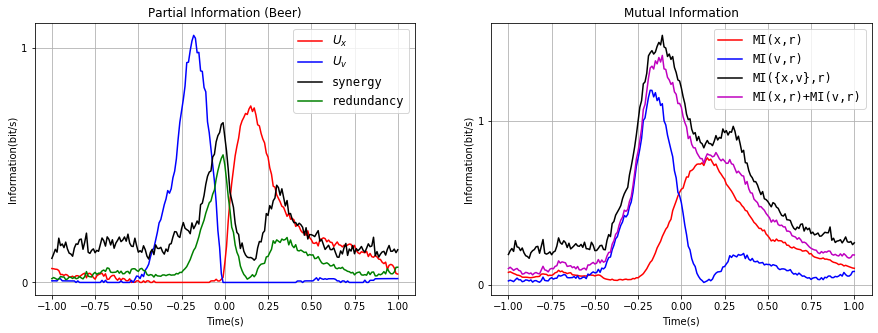

In [12]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)')
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information')
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

# Fake Spike

## parameters for NGD model and Spike generator

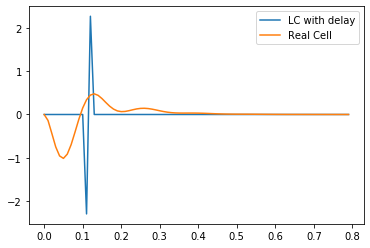

In [13]:
T = np.arange(0,0.8,dt)
TKLC = np.zeros_like(T)
Lambda = 0.455
TKLC[11] = 1-Lambda+(Lambda/Dt)
TKLC[12] = -(Lambda/Dt)
TKLC = TKLC
plt.plot(T, -TKLC*0.05, label = 'LC with delay')
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]), label = 'Real Cell')
plt.legend()

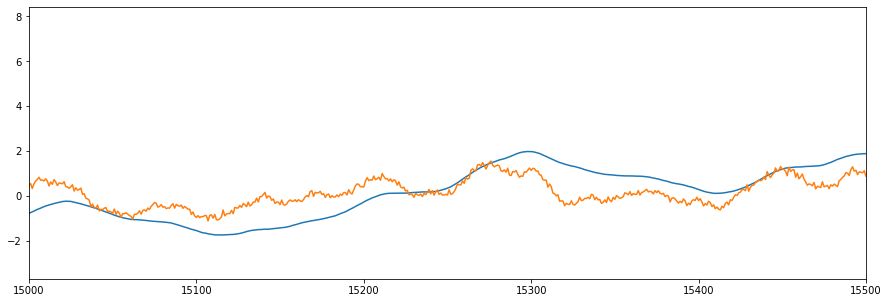

In [14]:
yLC_list = [np.convolve(x, TKLC, 'full')[:len(x)]*dt  for x in x_list]

i=0
plt.plot(x_list[i])
plt.plot(yLC_list[i]*50)

plt.xlim([15000, 15500])
plt.gcf().set_size_inches(15,5)

## LC model

In [15]:
y_list = yLC_list

## $\gamma_{mean}$

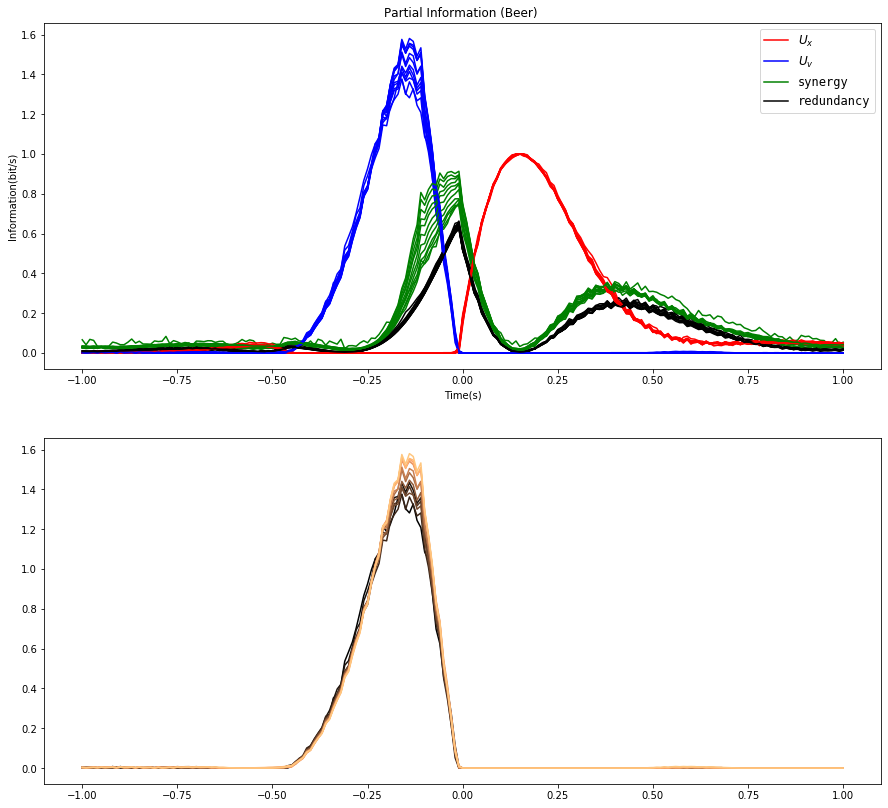

In [16]:
fig, (ax2,ax3) = plt.subplots(2, 1)
fig.set_size_inches(15, 14)
UxH = []
r_mean_list = np.arange(2,60,5)
ax3.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(r_mean_list)))))
for rrate in r_mean_list:
    FakeSpike_list = [0]*len(x_list)
    ystate_list = [0]*len(x_list)
    time_ystate_list = [0]*len(x_list)
    for i in np.arange(len(x_list)):
        y = y_list[i].copy()
        r = NL(-y+np.mean(y), 0)
        ratio = sum(r)/T_list[i][-1]/(rrate)
        FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
        ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
    # -----------------------------------------------------------------------------------------------------
    window = [-1,1] # second
    LC_Information_list = [0]*len(y_list)
    for i in range(len(y_list)):
        timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
    Information_list = LC_Information_list.copy()
    UxH.append(max(Information_list[i][('Beer','UIx')]))
    # -----------------------------------------------------------------------------------------------------
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')]/max(Information_list[i][('Beer','UIx')]), 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]), 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')]/max(Information_list[i][('Beer','UIx')]), 'g-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')]/max(Information_list[i][('Beer','UIx')]), 'k-')
    ax2.set_title('Partial Information (Beer) ')
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]))

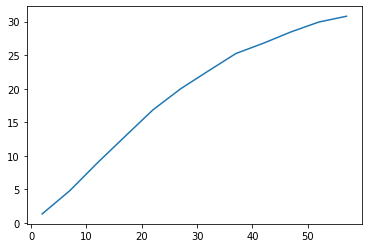

In [17]:
plt.plot(r_mean_list, UxH)

## $\theta$

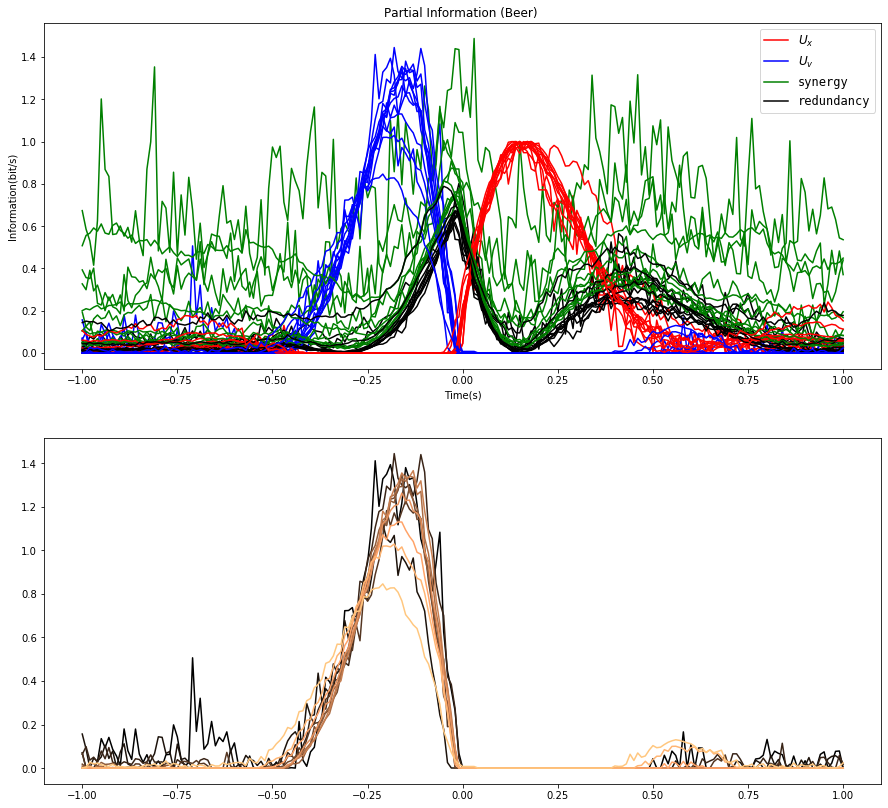

In [22]:
fig, (ax2,ax3) = plt.subplots(2, 1)
fig.set_size_inches(15, 14)
UxH = []
# theta_list = np.linspace(min(-y_list[i]), np.mean(-y_list[i]), 10, endpoint=True)
theta_list = np.arange(-3,3.,0.5)*np.std(-y_list[i])+np.mean(-y_list[i])
ax3.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(theta_list)))))
for theta in theta_list:
    FakeSpike_list = [0]*len(x_list)
    ystate_list = [0]*len(x_list)
    time_ystate_list = [0]*len(x_list)
    for i in np.arange(len(x_list)):
        y = y_list[i].copy()
        r = NL(-y, theta)
        ratio = sum(r)/T_list[i][-1]/2
        FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
        ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
    # -----------------------------------------------------------------------------------------------------
    window = [-1,1] # second
    LC_Information_list = [0]*len(y_list)
    for i in range(len(y_list)):
        timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
    Information_list = LC_Information_list.copy()
    UxH.append(max(Information_list[i][('Beer','UIx')]))
    # -----------------------------------------------------------------------------------------------------
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')]/max(Information_list[i][('Beer','UIx')]), 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]), 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')]/max(Information_list[i][('Beer','UIx')]), 'g-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')]/max(Information_list[i][('Beer','UIx')]), 'k-')
    ax2.set_title('Partial Information (Beer) ')
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]))

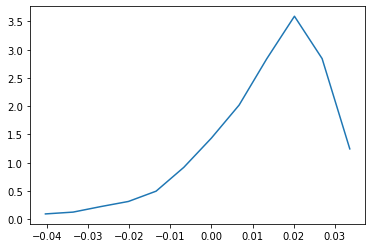

In [19]:
plt.plot(theta_list, UxH)

## $\Gamma$

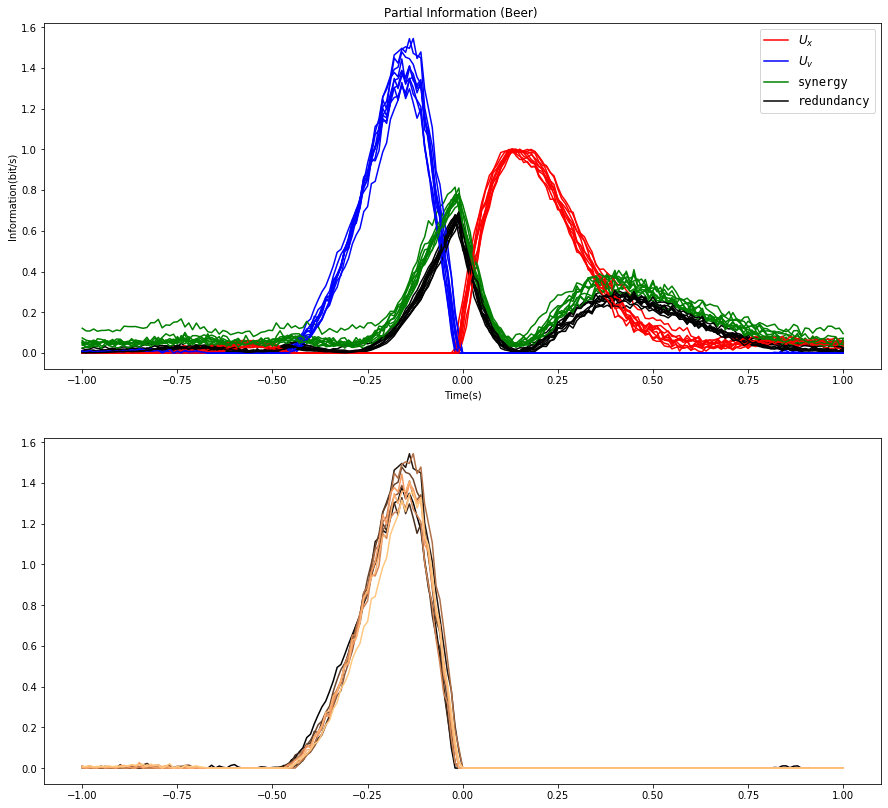

In [23]:
fig, (ax2,ax3) = plt.subplots(2, 1)
fig.set_size_inches(15, 14)
UxH = []
Gamma_list = np.arange(1,20,2) 
ax3.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Gamma_list)))))
for Gamma in Gamma_list:
    FakeSpike_list = [0]*len(x_list)
    ystate_list = [0]*len(x_list)
    time_ystate_list = [0]*len(x_list)
    for i in np.arange(len(x_list)):
        y = y_list[i].copy()
        r = NL(-y+np.mean(y), 0)
        ratio = sum(r)/T_list[i][-1]/2
        FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, Gamma)
        ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
    # -----------------------------------------------------------------------------------------------------
    window = [-1,1] # second
    LC_Information_list = [0]*len(y_list)
    for i in range(len(y_list)):
        timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
    Information_list = LC_Information_list.copy()
    UxH.append(max(Information_list[i][('Beer','UIx')]))
    # -----------------------------------------------------------------------------------------------------
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')]/max(Information_list[i][('Beer','UIx')]), 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]), 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')]/max(Information_list[i][('Beer','UIx')]), 'g-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')]/max(Information_list[i][('Beer','UIx')]), 'k-')
    ax2.set_title('Partial Information (Beer) ')
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]/max(Information_list[i][('Beer','UIx')]))

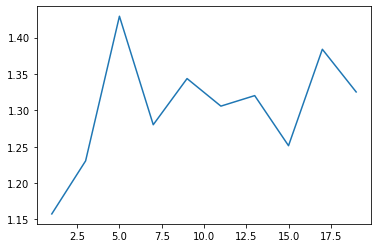

In [21]:
plt.plot(Gamma_list, UxH)